# 1st Project : Unsupervised Learning Trading Strategy

Steps to do : 

- Download SP500 stocks prices data. 
- Calculated different technical indicators and features for each stock. 
- Aggregate on monthly level and filter for each month only top 150 most liquid stocks.
- Calculate monthly returns for different time-horizons to add to features.
- Download Fama-French Factors and calculate rolling factor betas for each stock.
- For each month fit a K-means clustering model to group similar assets based on their features.
- For each month select assets based on the cluster and form a protofolio based on Efficient Frontier max sharpe ratio portofoli optimizations.
- Visualize the protofolio returns and compare to SP500 returns.

Limitations : We are going to use most recent SP500 stocks list, which means that there may be a survivorship bias in the list, in reality you have to use survivorship free data.  
(Survivorship bias : a stock that has been removed from the index, we wont take them into consideration) 

In [4]:
# Importing required libs and functions
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import datetime as dt
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import statsmodels.api as sm
import yfinance as yf
import pandas_ta
import warnings
warnings.filterwarnings('ignore')

Step 1 : DATA LOADING

In [5]:
 # Load Data and choose the first (0) DataFrame
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
 
 #Replace symbol dot to avoid errors and extract company's symbols 
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
 
symbols_list = sp500['Symbol'].unique().tolist()
 #Download Data until current date
end_date = '2024-01-01'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
 
 # Download from Yahoo finance the symbols data
df = yf.download(tickers = symbols_list, 
                  start = start_date, 
                  end = end_date).stack()

df.index.names = ['date', 'ticker']

df.columns = df.columns.str.lower()

df

[*********************100%%**********************]  503 of 503 completed

2 Failed downloads:
['SOLV', 'GEV']: Exception("%ticker%: Data doesn't exist for startDate = 1451797200, endDate = 1704085200")


Price               adj close       close        high         low        open  \
date       ticker                                                               
2016-01-04 A        38.072575   40.689999   41.189999   40.340000   41.060001   
           AAL      39.095455   40.910000   41.349998   40.299999   41.290001   
           AAPL     23.946918   26.337500   26.342501   25.500000   25.652500   
           ABBV     40.392155   57.610001   58.320000   56.400002   58.060001   
           ABT      36.778622   42.930000   44.049999   42.500000   43.939999   
...                       ...         ...         ...         ...         ...   
2023-12-29 XYL     114.027420  114.360001  114.680000  113.930000  114.089996   
           YUM     130.009369  130.660004  131.250000  130.210007  130.410004   
           ZBH     121.471581  121.699997  122.400002  121.239998  121.459999   
           ZBRA    273.329987  273.329987  276.309998  272.769989  274.730011   
           ZTS     196.923355  197.369995  198.009995  196.250000  196.679993   

Price                   volume  
date       ticker               
2016-01-04 A         3287300.0  
           AAL      12037200.0  
           AAPL    270597600.0  
           ABBV     10308400.0  
           ABT      12227500.0  
...                        ...  
2023-12-29 XYL        698900.0  
           YUM       1196800.0  
           ZBH        849600.0  
           ZBRA       251300.0  
           ZTS       1007200.0  

[990484 rows x 6 columns]

Step 2: Calculate features and technical indicators for each stock

- Garman-Klass Volatility (measure volatility of given asset, mostly used in Forex)
- RSI
- Bollinger Bands
- ATR
- MACD
- Dollar Volume

\begin{equation}
\text{Garman-Klass Volatility} = \frac{(\ln(\text{High}) - \ln(\text{Low}))^2}{2} - (2\ln(2) - 1)(\ln(\text{Adj Close}) - \ln(\text{Open}))^2
\end{equation}

In [6]:
df['garman_klass_vol'] = ((np.log(df['high'])-np.log(df['low']))**2)/2-(2*np.log(2)-1)*((np.log(df['adj close'])-np.log(df['open']))**2)

df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))
                                                     
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
                                                          
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
                                                          
df['bb_high'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

# Calculate ATR. ATR needs 3 columns

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

df['dollar_volume'] = (df['adj close']*df['volume'])/1e6


Step 3 : Aggregate to monthly level and filter top 150 most liquid stocks for each month.

* To reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency.

In [7]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   df.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

* Calculate 5-year rolling average of dollar volume for each stocks before filtering.

In [8]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())

data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

Step 4: Calculate Monthly Returns for different time horizons as features.

* To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [9]:
def calculate_returns(df):

    outlier_cutoff = 0.005 # All values above the threshold will be assigned the value of the outlier

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag) # Caluclate given return for each lag
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df
    
    
data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()


Step 5: Download Fama-French Factors and Calculate Rolling Factor Betas.

* We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.

* The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.

* We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [10]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()


- Filter out stocks with less than 10 month of data 

In [11]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

* Calculate Rolling Factor Betas.

In [12]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'], 
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

* Join the rolling factors data to the main features dataframe.

In [13]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

# Replace missing values for each factor with the mean value
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean())) 

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10184 entries, (Timestamp('2018-01-31 00:00:00'), 'AAL') to (Timestamp('2023-12-31 00:00:00'), 'UBER')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10184 non-null  float64
 1   rsi               10184 non-null  float64
 2   bb_low            10184 non-null  float64
 3   bb_mid            10184 non-null  float64
 4   bb_high           10184 non-null  float64
 5   atr               10184 non-null  float64
 6   macd              10184 non-null  float64
 7   return_1m         10184 non-null  float64
 8   return_2m         10184 non-null  float64
 9   return_3m         10184 non-null  float64
 10  return_6m         10184 non-null  float64
 11  return_9m         10184 non-null  float64
 12  return_12m        10184 non-null  float64
 13  Mkt-RF            10184 non-null  float64
 14  SMB               10184 non-null  float64
 15  HML       

### At this point we have to decide on what ML model and approach to use for predictions etc.


Step 6: For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.

### K-Means Clustering
* You may want to initialize predefined centroids for each cluster based on your research.

* For visualization purpose we will initially rely on the ‘k-means++’ initialization.

* Then we will pre-define our centroids for each cluster.

In [19]:
from sklearn.cluster import KMeans

#data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init= initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)

In [21]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,5] , cluster_0.iloc[:,1] , color = 'red', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,5] , cluster_1.iloc[:,1] , color = 'green', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,5] , cluster_2.iloc[:,1] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,5] , cluster_3.iloc[:,1] , color = 'black', label='cluster 3')
    
    plt.legend()
    plt.show()
    return


In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():
    
    g = data.xs(i, level=0)
    
    plt.title(f'Date {i}')
    
    plot_clusters(g)

Apply pre - defined centroids 

In [15]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

Step 7: For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

* First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

* Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.


In [23]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:
    
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
    

 Define portfolio optimization function

* We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

* To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

* Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).

In [73]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):
    
    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)
    
    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)
    
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    
    weights = ef.max_sharpe()
    
    return ef.clean_weights()


* Download Fresh Daily Prices Data only for short listed stocks.

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

* Calculate daily returns for each stock which could land up in our portfolio.

* Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

* If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

* Calculated each day portfolio return.

In [74]:
returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    
    try:

        end_date = (pd.to_datetime(start_date)+pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')

        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date)-pd.DateOffset(months=12)).strftime('%Y-%m-%d')

        optimization_end_date = (pd.to_datetime(start_date)-pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        optimization_df = new_df[optimization_start_date:optimization_end_date]['Adj Close'][cols]
        
        success = False
        
        try:
            weights = optimize_weights(prices=optimization_df,
                                   lower_bound=round(1/(len(optimization_df.columns)*2),3))

            weights = pd.DataFrame(weights, index=pd.Series(0))
            
            success = True
            
        except:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights')
        
        
        if success==False:
            
            weights = pd.DataFrame([1/len(optimization_df.columns) for i in range(len(optimization_df.columns))],
                                     index=optimization_df.columns.tolist(),
                                     columns=pd.Series(0)).T
        
        temp_df = returns_dataframe[start_date:end_date]

        
        temp_df = temp_df.stack().to_frame('return').reset_index(level=0)\
                   .merge(weights.stack().to_frame('weight').reset_index(level=0, drop=True),
                          left_index=True,
                          right_index=True)\
                   .reset_index().set_index(['Date', 'Ticker']).unstack().stack()
        
        temp_df.index.names = ['date', 'ticker']
        
        temp_df['weighted_return'] = temp_df['return']*temp_df['weight']
        
        temp_df = temp_df.groupby(level=0)['weighted_return'].sum().to_frame('Strategy Return')
        
        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
        
    except Exception as e:
        print(e)

portfolio_df = portfolio_df.drop_duplicates()


Max Sharpe Optimization failed for 2022-06-01, Continuing with Equal-Weights
'return'


Step 8: Visualize Portfolio returns and compare to SP500 returns.

In [78]:
portfolio_df

,Strategy Return,SPY Buy&Hold
2018-02-01,0.000559,-0.001135
2018-02-02,-0.019022,-0.022011
2018-02-05,-0.037617,-0.042722
2018-02-06,0.011317,0.019511
2018-02-07,-0.005196,-0.005440
...,...,...
2023-12-22,0.000178,0.002008
2023-12-26,0.005906,0.004214
2023-12-27,0.001901,0.001806
2023-12-28,0.000631,0.000378


In [81]:
spy = yf.download(tickers='SPY',
                  start='2018-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)


[*********************100%%**********************]  1 of 1 completed


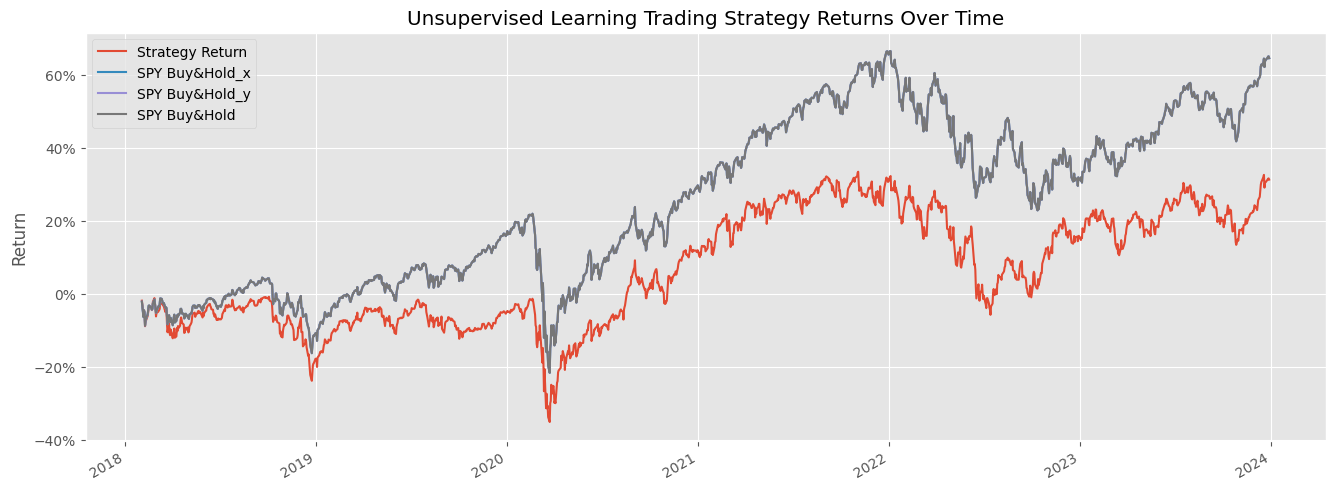

In [83]:
import matplotlib.ticker as mtick

plt.style.use('ggplot')

portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1

portfolio_cumulative_return[:'2024-01-01'].plot(figsize=(16,6))

plt.title('Unsupervised Learning Trading Strategy Returns Over Time')

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))

plt.ylabel('Return')

plt.show()